<a href="https://colab.research.google.com/github/Reinaldo0/ProjetoIA-A3/blob/main/ProjetoA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16291 entries, 0 to 16290
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  float64
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None
               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16291.000000  16291.000000  16291.000000  16291.000000  16291.000000   
mean    8290.190228   2006.405561      0.265647      0.147731      0.078833   
std     4792.654450      5.8

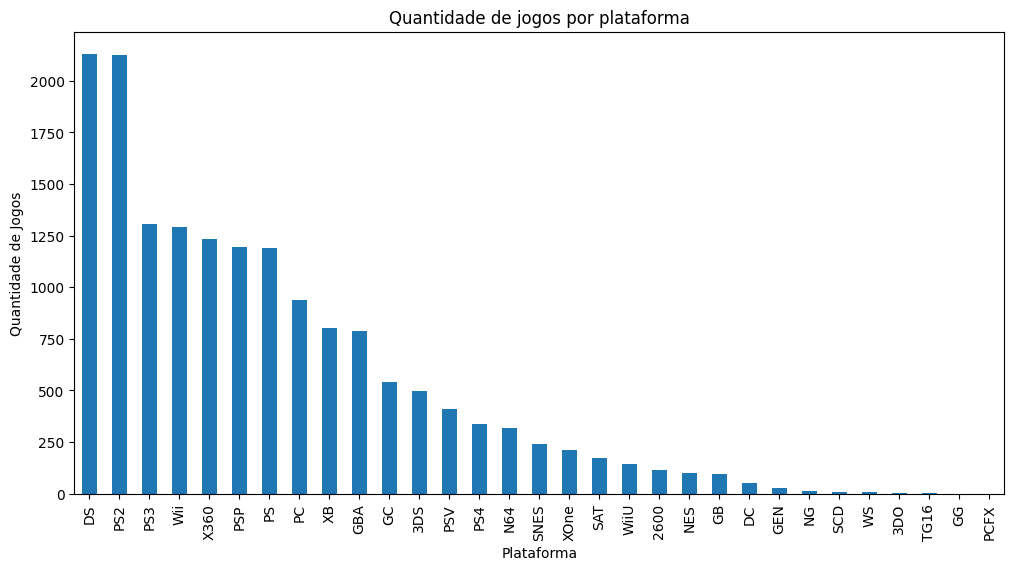

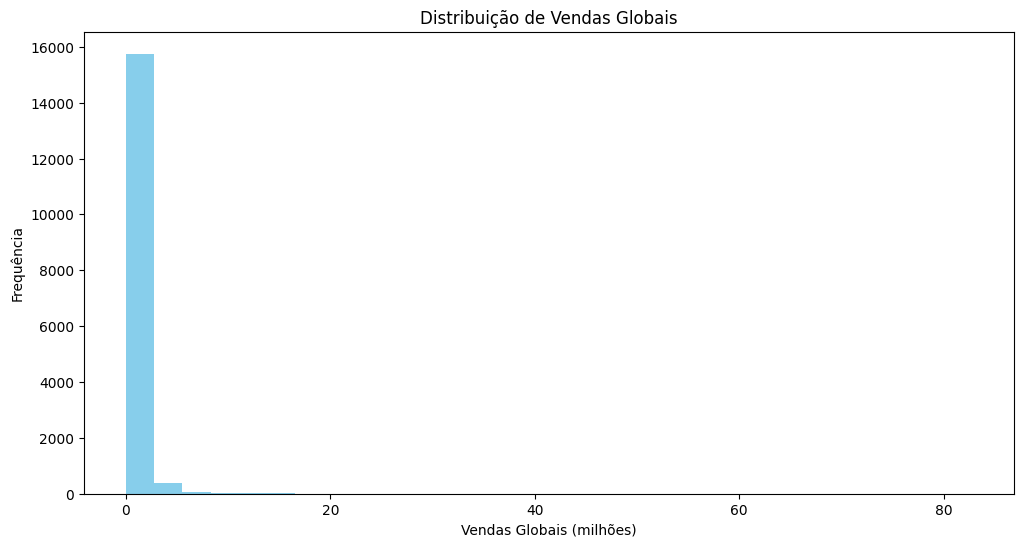


Jogos mais vendidos por plataforma:
      Platform                                    Name  Global_Sales
89        2600                                 Pac-Man          7.81
238       2600                                Pitfall!          4.50
12411      3DO                             Policenauts          0.06
14731      3DO                             Bust-A-Move          0.02
32         3DS                     Pokemon X/Pokemon Y         14.35
42         3DS                            Mario Kart 7         12.21
631         DC                         Sonic Adventure          2.42
949         DC                              Crazy Taxi          1.81
6           DS                   New Super Mario Bros.         30.01
10          DS                              Nintendogs         24.76
4           GB                Pokemon Red/Pokemon Blue         31.37
5           GB                                  Tetris         30.26
25         GBA           Pokemon Ruby/Pokemon Sapphire         15.

In [12]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Função para carregar e preparar os dados
def carregar_dados():
    dados = pd.read_csv("vgsales.csv")
    return dados

# Função para carregar e preparar os dados limpos
def carregar_dados_limpos():
    dados_limpos = pd.read_csv("vgsales_cleaned.csv")
    return dados_limpos

# Função para identificar e remover linhas com problemas
def limpar_dados(dados):
    """
    Identifica e remove linhas com valores nulos ou com formato inconsistente.
    """
    # Identifica linhas com problemas
    linhas_nulas = dados[dados.isnull().any(axis=1)]
    linhas_inconsistentes = pd.DataFrame()
    for col in dados.select_dtypes(include=[np.number]).columns:
        nao_numerico = dados[~dados[col].apply(lambda x: np.issubdtype(type(x), np.number))]
        linhas_inconsistentes = pd.concat([linhas_inconsistentes, nao_numerico])

    # Combina ambos os DataFrames de linhas problemáticas e remove duplicatas
    problemas = pd.concat([linhas_nulas, linhas_inconsistentes]).drop_duplicates()

    # Remove as linhas problemáticas do DataFrame original
    dados_limpos = dados.drop(problemas.index)

    return dados_limpos

# Função para análise exploratória de dados (EDA)
def analise_exploratoria_dados(dados):
    """
    Realiza uma análise exploratória nos dados e retorna algumas visualizações.
    """
    # Verificar informações iniciais
    print(dados.info())

    # Exibir estatísticas descritivas
    print(dados.describe())

    # Distribuição por plataforma
    plt.figure(figsize=(12,6))
    dados['Platform'].value_counts().plot(kind='bar')
    plt.title("Quantidade de jogos por plataforma")
    plt.xlabel("Plataforma")
    plt.ylabel("Quantidade de Jogos")
    plt.show()

    # Distribuição de vendas
    plt.figure(figsize=(12,6))
    dados['Global_Sales'].plot(kind='hist', bins=30, color='skyblue')
    plt.title("Distribuição de Vendas Globais")
    plt.xlabel("Vendas Globais (milhões)")
    plt.ylabel("Frequência")
    plt.show()

# Função para recomendar os jogos mais vendidos por plataforma
def recomendar_jogos_mais_vendidos_geral(dados, top_n=2):
    """
    Retorna os 'top_n' jogos mais vendidos para cada plataforma,
    ordenados por plataforma.
    """
    jogos_principais = dados.sort_values(by=['Platform', 'Global_Sales'], ascending=[True, False]).groupby('Platform').head(top_n)
    return jogos_principais[['Platform', 'Name', 'Global_Sales']]

# Função para recomendar o melhor jogo de cada gênero
def recomendar_jogo_mais_vendido_por_genero(dados):
    """
    Recomenda o jogo mais vendido para cada gênero com base nas vendas globais.
    """
    jogo_mais_vendido_por_genero = dados.loc[dados.groupby('Genre')['Global_Sales'].idxmax()]
    return jogo_mais_vendido_por_genero[['Genre', 'Name', 'Global_Sales']]

# Função de pré-processamento de dados
def preprocessar_dados(dados):
    """
    Realiza o pré-processamento dos dados, incluindo tratamento de valores ausentes,
    normalização de variáveis e separação de conjunto de treino e teste.
    """
    # Tratamento de valores ausentes
    dados = dados.dropna(subset=['Year', 'Global_Sales'])

    # Normalização (escala) de variáveis
    dados.loc[:, 'Global_Sales'] = (dados['Global_Sales'] - dados['Global_Sales'].mean()) / dados['Global_Sales'].std()

    # Divisão em conjunto de treino e teste
    X = dados[['Year', 'Platform', 'Genre', 'Publisher']].copy()
    X = pd.get_dummies(X)  # Codificação one-hot
    y = (dados['Global_Sales'] > dados['Global_Sales'].mean()).astype(int)  # Classificação binária baseada na média

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_treino, X_teste, y_treino, y_teste

# Função para treinar o modelo
def treinar_modelo(X_treino, y_treino):
    """
    Treina um modelo Random Forest nos dados de treino.
    """
    modelo = RandomForestClassifier(random_state=42)
    modelo.fit(X_treino, y_treino)
    return modelo

# Função para avaliar o modelo
def avaliar_modelo(modelo, X_teste, y_teste):
    """
    Avalia o modelo com métricas de classificação e exibe os resultados.
    """
    y_pred = modelo.predict(X_teste)
    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred)
    recall = recall_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)

    print("\nMétricas do Modelo:")
    print(f"Acurácia: {acuracia:.2f}")
    print(f"Precisão: {precisao:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Função principal para executar o pipeline
def main():

    # Carregar os dados
    dados = carregar_dados()

    # Limpa o dataset, removendo linhas com problemas
    dados_limpos = limpar_dados(dados)

    # Salva o dataset limpo em um novo arquivo CSV
    dados_limpos.to_csv("vgsales_cleaned.csv", index=False)

    # Carregar os dados limpos
    dados_limpos = carregar_dados_limpos()

    # Análise exploratória de dados
    analise_exploratoria_dados(dados_limpos)

    # Recomendação de jogos mais vendidos por plataforma
    jogos_mais_vendidos_geral = recomendar_jogos_mais_vendidos_geral(dados_limpos)
    print("\nJogos mais vendidos por plataforma:")
    print(jogos_mais_vendidos_geral)

    jogos_mais_vendidos_genero = recomendar_jogo_mais_vendido_por_genero(dados_limpos)
    print("\nJogos mais vendidos por gênero:")
    print(jogos_mais_vendidos_genero)

    # Pré-processamento e divisão dos dados
    X_treino, X_teste, y_treino, y_teste = preprocessar_dados(dados_limpos)

    # Treinamento do modelo
    modelo = treinar_modelo(X_treino, y_treino)

    # Avaliação do modelo
    avaliar_modelo(modelo, X_teste, y_teste)

# Executa o pipeline
main()